# Energy Price Prediction Project

[Energy market in Italy](https://en.wikipedia.org/wiki/Italian_Power_Exchange) takes place every day in order to determine the energy price (**PUN**) for the subsequent day.

The PUN is determined as the balance between the supply and demand subject to some conditions on the transit of energy between different zones of Italy and between Italy and neighboring countries.

The aim of this project is to predict the energy price starting from the publicly available data on the [energy market's managing institution (GME)](http://www.mercatoelettrico.org/It/default.aspx). Reliable price predictions are very useful to energy producers for two reasons

1. it allows them to sell their energy at the best possible price and
2. it avoids for them not to succeed in the selling, incurring in the possibility of having to dissipate their energy with all the related costs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Cleaning

In [2]:
import xml.etree.ElementTree
import zipfile
import os

Some helper functions to read the xml files in which I have the data, loop through the zip files in which they are compressed and through the various zip files in the data folder:

In [3]:
def import_xml_file(file, row_names, cols):
    '''
    Reads xml file and outputs list of data
    Inputs:
        file -> file name
        row_names -> list of rows tags identifier
        cols -> list of columns tags identifier
    '''
    data = xml.etree.ElementTree.parse(file).getroot()
    all_data = []
    for row_name in row_names:
        for row_data in data.findall(row_name):
            row = []
            for col in cols:
                col_data = row_data.find(col).text
                row.append(col_data)
            all_data.append(row)
    
    return all_data

def import_xml_zip_file(folder, zip_file, row_names, cols, out_cols):
    '''
    Loops through xml files in zip archive and outputs a pandas dataframe with all xml files data
    Uses import_xml_file
    Inputs:
        folder -> zip file folder
        zip_file -> zip file name
        row_names -> list of rows tags identifier
        cols -> list of columns tags identifier
        out_cols -> columns names for the pandas dataframe
    '''
    with zipfile.ZipFile('{}/{}'.format(folder, zip_file)) as z:
        all_data = []
        for file in z.namelist():
            f = z.open(file)
            file_data = import_xml_file(f, row_names, cols)
            all_data = all_data + file_data
    
    xml_df = pd.DataFrame(all_data, columns=out_cols)
    return xml_df

def import_xml_from_folder(folder, file_name_path, row_names, cols, out_cols, int_cols, num_cols, date_cols):
    '''
    Loops through all zip archives in a folder and outputs a pandas dataframe with all the zipped data
    Uses import_xml_zip_file
    Inputs:
        folder -> zip file folder
        file_name_path -> start of files name to search for
        row_names -> list of rows tags identifier
        cols -> list of columns tags identifier
        out_cols -> columns names for the pandas dataframe
        int_cols -> list of columns to convert to int
        num_cols -> list of columns to convert to numeric
        date_cols -> list of columns to convert to date
    '''
    directory = os.fsencode(folder)
    out_df = pd.DataFrame(columns=out_cols)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith(file_name_path) and (filename.endswith('.zip') or filename.endswith('.7z')):
            df = import_xml_zip_file(folder, filename, row_names, cols, out_cols)
            out_df = out_df.append(df)
    
    for col in int_cols:
        out_df[col] = pd.to_numeric(out_df[col])
    for col in num_cols:
        out_df[col] = out_df[col].apply(lambda x: x.replace(',', '.'))
        out_df[col] = pd.to_numeric(out_df[col])
    for col in date_cols:
        out_df[col] = pd.to_datetime(out_df[col])
    
    return out_df.reset_index(drop=True)

Import the data.

- Prices data: one row per day and hour, PUN is the national price of energy and the variable to predict.
- Demand data: estimates of the energy need for each zone in Italy and for the whole country; again there is one row per day and hour.
- Transit data: limits of energy exchange between neighboring zones in Italy and between Italy and neighboring countries, these limits condition the energy price. This dataset has one row per day, hour, zone of origin and zone of destination.

In [4]:
pun = import_xml_from_folder(folder='../data/raw',
                             file_name_path='MGP_Prezzi',
                             row_names=['Prezzi'],
                             cols=['Data', 'Ora', 'Mercato', 'PUN'],
                             out_cols=['date', 'hour', 'market', 'pun'],
                             int_cols=['hour'],
                             num_cols=['pun'],
                             date_cols=['date'])
demand = import_xml_from_folder(folder='../data/raw',
                                file_name_path='MGP_StimeFabbisogno',
                                row_names=['Fabbisogno', 'StimeFabbisogno', 'stimeFabbisogno', 'marketintervaldetail'],
                                cols=['Data', 'Ora', 'Mercato', 'Totale', 'CNOR', 'CSUD', 'NORD', 'SARD', 'SICI', 'SUD'],
                                out_cols=['date', 'hour', 'market', 'italy', 'cnorth', 'csouth', 'north', 'sardinia', 'sicily', 'south'],
                                int_cols=['hour'],
                                num_cols=['italy', 'cnorth', 'csouth', 'north', 'sardinia', 'sicily', 'south'],
                                date_cols=['date'])
transit_limit = import_xml_from_folder(folder='../data/raw',
                                       file_name_path='MGP_LimitiTransito',
                                       row_names=['LimitiTransito'],
                                       cols=['Data', 'Ora', 'Mercato', 'Da', 'A', 'Limite', 'Coefficiente'],
                                       out_cols=['date', 'hour', 'market', 'zone_from', 'zone_to', 'limit', 'coefficient'],
                                       int_cols=['hour'],
                                       num_cols=['limit', 'coefficient'],
                                       date_cols=['date'])

In [5]:
pun.head()

,date,hour,market,pun
0,2014-01-17,1,MGP,50.393484
1,2014-01-17,2,MGP,45.700000
2,2014-01-17,3,MGP,41.973579
3,2014-01-17,4,MGP,40.261427
4,2014-01-17,5,MGP,40.103296


In [6]:
demand.head()

,date,hour,market,italy,cnorth,csouth,north,sardinia,sicily,south
0,2014-01-17,1,MGP,28430,3174,4275,15963,818,1775,2425
1,2014-01-17,2,MGP,26631,2966,3909,15145,756,1646,2209
2,2014-01-17,3,MGP,25711,2732,3727,14865,727,1570,2090
3,2014-01-17,4,MGP,25468,2688,3655,14830,719,1531,2045
4,2014-01-17,5,MGP,25725,2715,3660,15024,727,1518,2081


In [7]:
transit_limit.head()

,date,hour,market,zone_from,zone_to,limit,coefficient
0,2014-01-26,1,MGP,AUST,NORD,10000.0,1.0
1,2014-01-26,2,MGP,AUST,NORD,10000.0,1.0
2,2014-01-26,3,MGP,AUST,NORD,10000.0,1.0
3,2014-01-26,4,MGP,AUST,NORD,10000.0,1.0
4,2014-01-26,5,MGP,AUST,NORD,10000.0,1.0


I want the transit data to have the structure of one row per day and hour, so I add a feature for each pair of zones of origin and destination.

In [8]:
transit_limit['from_to'] = transit_limit['zone_from'] + '-' + transit_limit['zone_to']

In [9]:
transit_limit = transit_limit.pivot_table(index=['date', 'hour'], columns='from_to', values='limit').reset_index()

In [10]:
print(pun.shape)
print(demand.shape)
print(transit_limit.shape)

(33600, 4)
(33600, 10)
(33600, 46)


In [11]:
print(pun['date'].min(), pun['date'].max())
print(demand['date'].min(), demand['date'].max())
print(transit_limit['date'].min(), transit_limit['date'].max())

2014-01-01 00:00:00 2017-10-31 00:00:00
2014-01-01 00:00:00 2017-10-31 00:00:00
2014-01-01 00:00:00 2017-10-31 00:00:00


Finally, I merge all the dataset on the date and hour columns.

In [12]:
market = pd.merge(left=pun, right=demand, how='inner', left_on=['date', 'hour'], right_on=['date', 'hour']).drop(['market_x', 'market_y'], axis=1)
market = pd.merge(left=market, right=transit_limit, how='inner', left_on=['date', 'hour'], right_on=['date', 'hour'])
market.to_pickle('../data/interim/market.pkl')

# Initial EDA

In [13]:
# market = pd.read_pickle('../data/interim/market.pkl')
market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33600 entries, 0 to 33599
Data columns (total 54 columns):
date         33600 non-null datetime64[ns]
hour         33600 non-null int64
pun          33600 non-null float64
italy        33600 non-null int64
cnorth       33600 non-null int64
csouth       33600 non-null int64
north        33600 non-null int64
sardinia     33600 non-null int64
sicily       33600 non-null int64
south        33600 non-null int64
AUST-NORD    33600 non-null float64
AUST-XAUS    23856 non-null float64
BRNN-GREC    33600 non-null float64
BRNN-SUD     33600 non-null float64
BSP-SLOV     33600 non-null float64
CNOR-CORS    33600 non-null float64
CNOR-CSUD    33600 non-null float64
CNOR-NORD    33600 non-null float64
COAC-SARD    33600 non-null float64
CORS-CNOR    33600 non-null float64
CORS-SARD    33600 non-null float64
CSUD-CNOR    33600 non-null float64
CSUD-SARD    33600 non-null float64
CSUD-SUD     33600 non-null float64
FOGN-SUD     33600 non-null float64


I start by adding year, month and day of week and looking at a correlation heatmap.

In [14]:
market['day_of_week'] = market['date'].dt.weekday
market['month'] = market['date'].dt.month
market['year'] = market['date'].dt.year

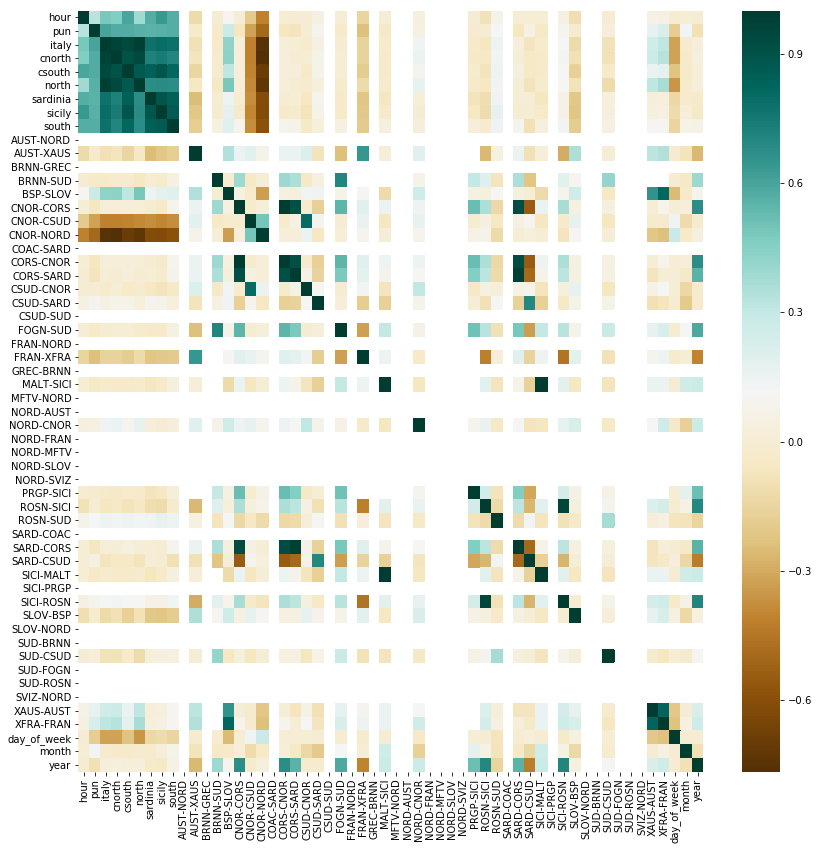

In [15]:
plt.figure(figsize=(14, 14))
sns.heatmap(market.corr(), cmap='BrBG');

There are many transit features which aren't correlated to anything: this is due to the fact that they have always the same value across all the dataset. These features aren't very informative so I'm dropping them right away.

In [16]:
unique_value_cols = [col for col in market.columns if len(market[col].unique()) == 1]

In [17]:
market.drop(unique_value_cols, axis=1, inplace=True)

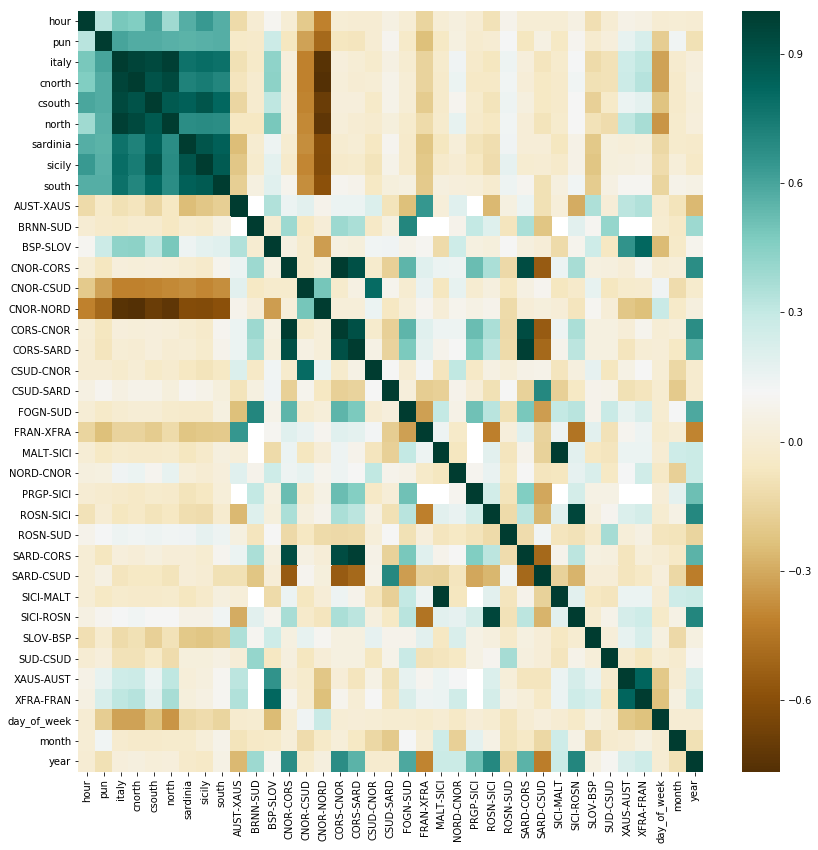

In [18]:
plt.figure(figsize=(14, 14))
sns.heatmap(market.corr(), cmap='BrBG');
# plt.savefig('../reports/figures/MVP_heatmap.png');

PUN is positively correlated to the energy demand in all the zones; it is also negatively correlated to the transit limits between some zones, especially the limits involving center-north of Italy.

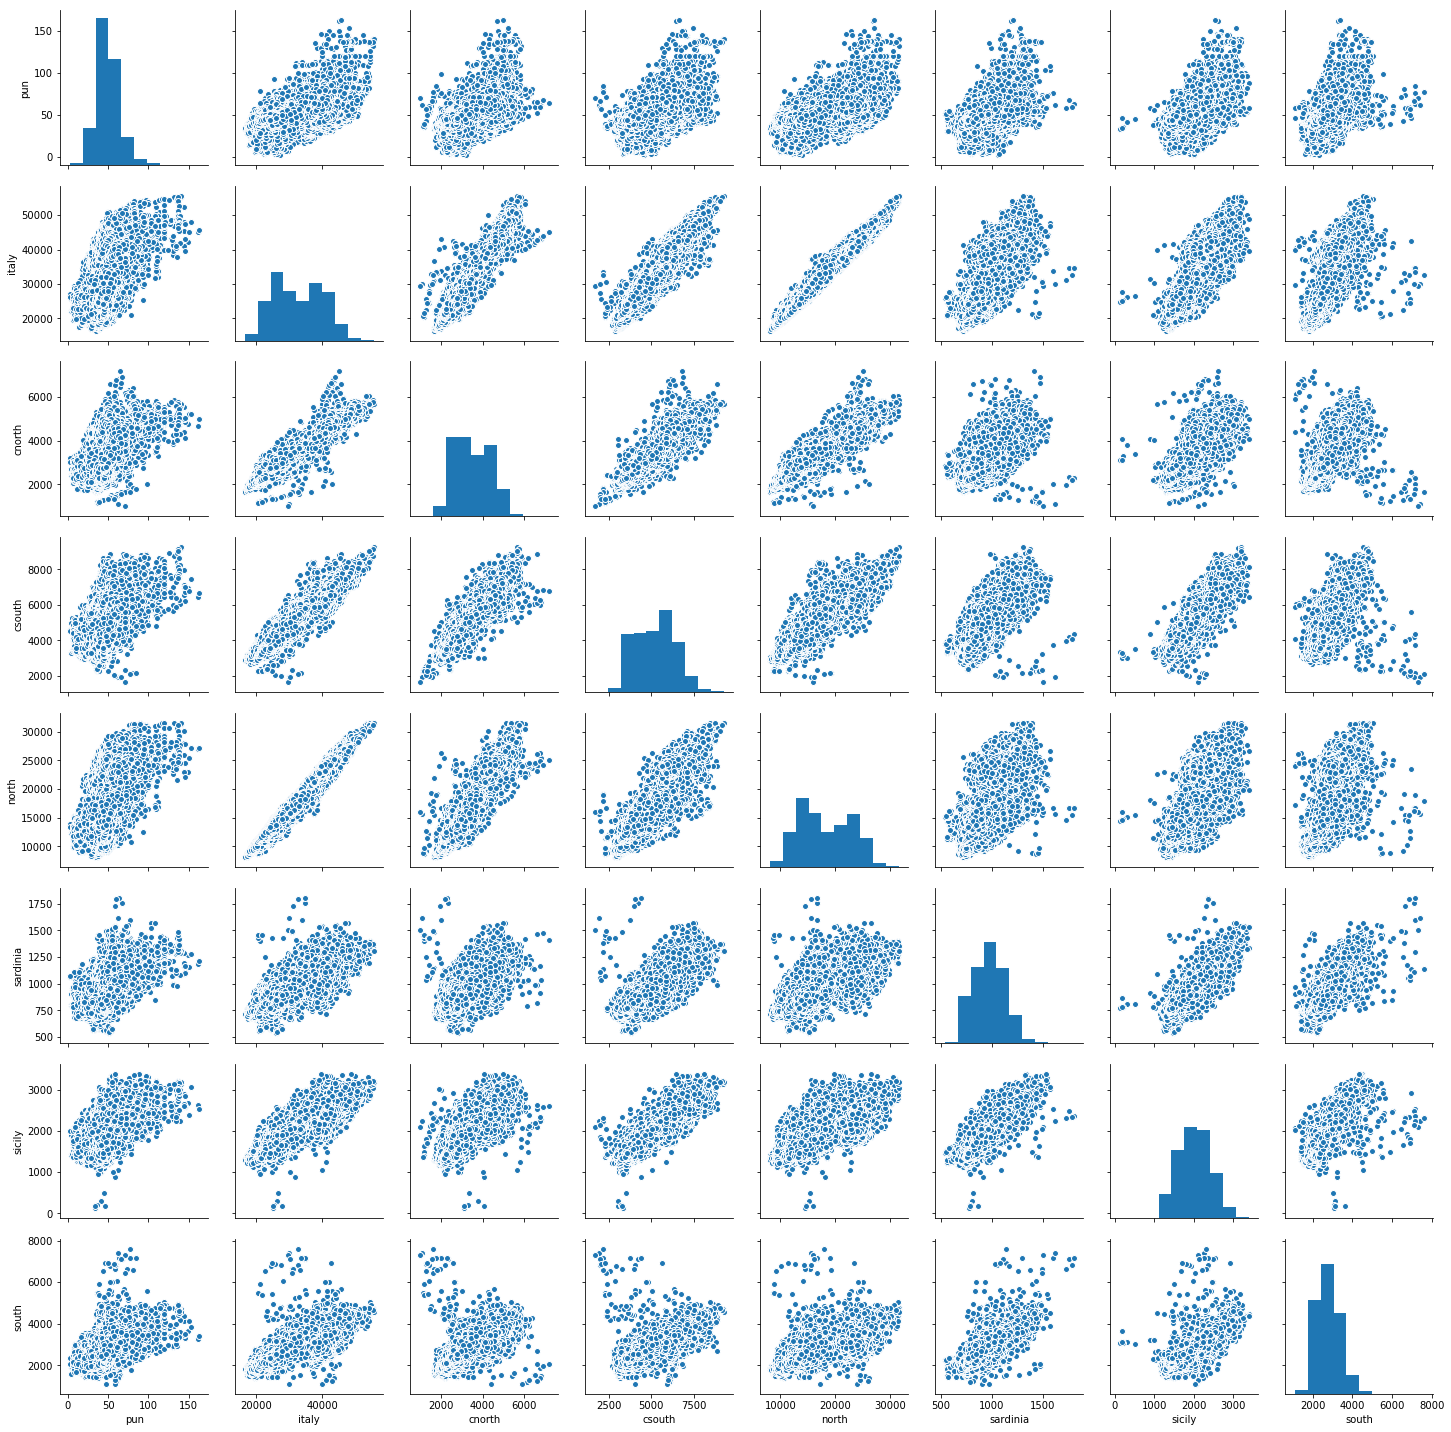

In [19]:
ax = sns.pairplot(market[['pun', 'italy', 'cnorth', 'csouth', 'north', 'sardinia', 'sicily', 'south']]);
# plt.savefig('../reports/figures/MVP_pairplot.png');

There is a slight linear relationship between PUN and demand, but there is also correlation between the demands from the various zones.

Now I'm going to see how the PUN varies through time-related variables:

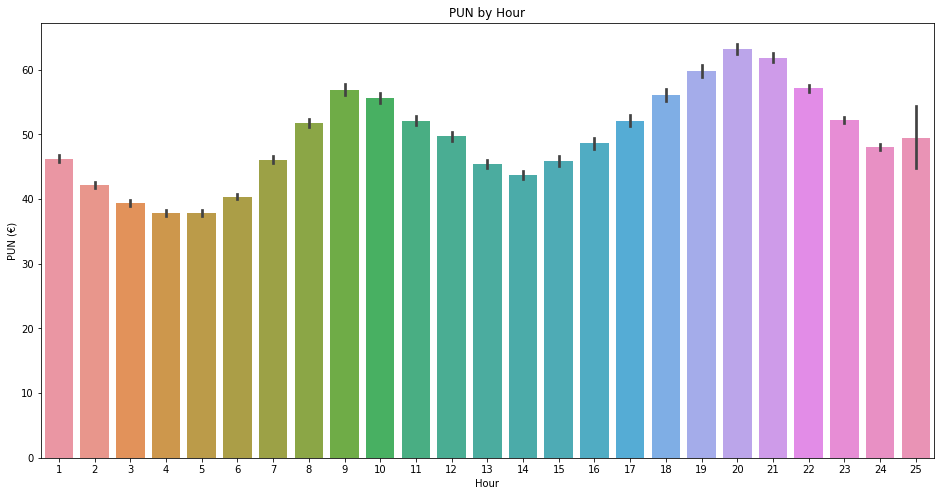

In [20]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=market['hour'], y=market['pun'], ax=ax)
ax.set_title('PUN by Hour')
ax.set_xlabel('Hour')
ax.set_ylabel('PUN (€)');
# plt.savefig('../reports/figures/MVP_PUN_by_hour.png');

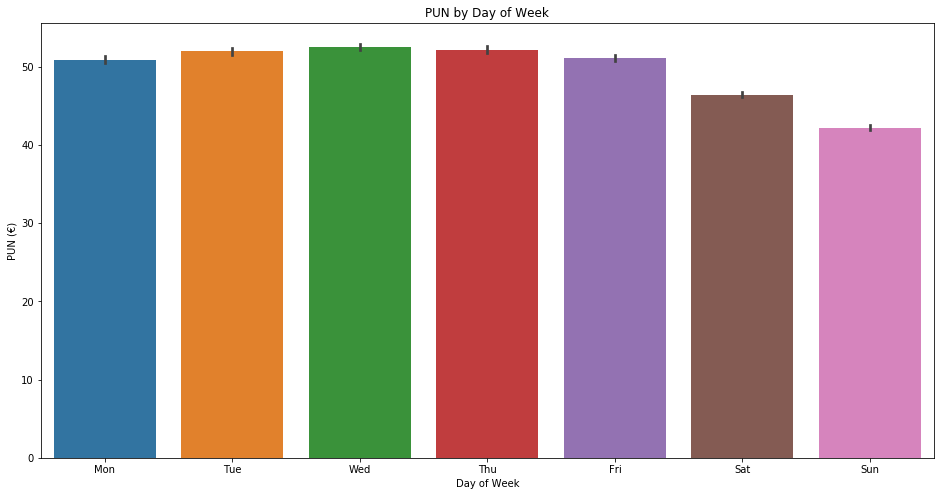

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=market['day_of_week'], y=market['pun'], ax=ax)
ax.set_title('PUN by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('PUN (€)')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);
# plt.savefig('../reports/figures/MVP_PUN_by_weekday.png');

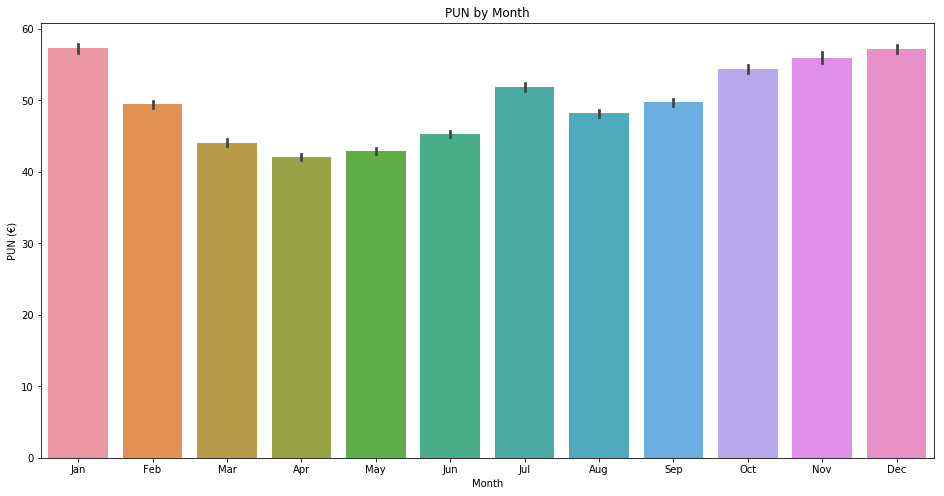

In [22]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=market['month'], y=market['pun'], ax=ax)
ax.set_title('PUN by Month')
ax.set_xlabel('Month')
ax.set_ylabel('PUN (€)')
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);
# plt.savefig('../reports/figures/MVP_PUN_by_month.png');

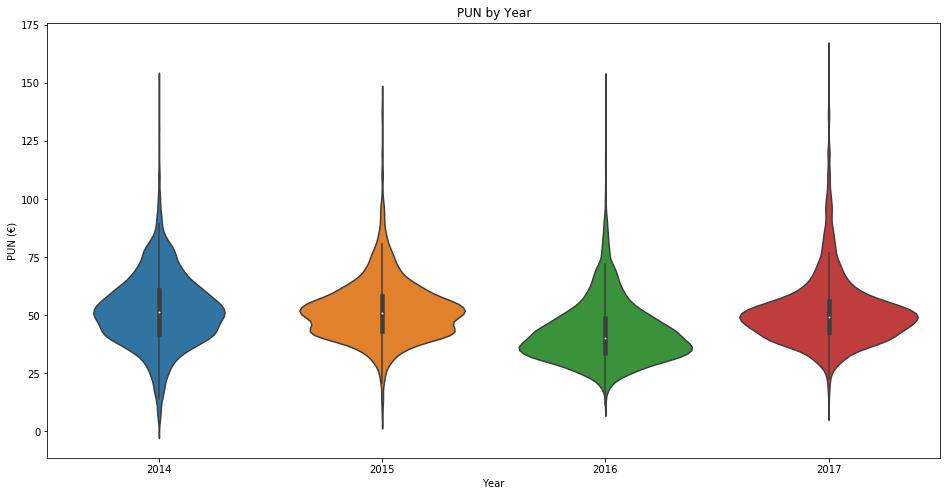

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.violinplot(x=market['year'], y=market['pun'], ax=ax)
ax.set_title('PUN by Year')
ax.set_xlabel('Year')
ax.set_ylabel('PUN (€)');
# plt.savefig('../reports/figures/MVP_PUN_by_year.png');

There are definitely some peaks in the price in certain hours of the day, especially the evening, and in the winter months; while the price is lower in the weekends.

There seems to be a significant plunge in the PUN for 2016 and it may be worth to take a closer look at it.

# Preprocessing

First of all I'm dropping the rows with the 25 hour: these represents the extra hour in the day when daylight saving time ends and are not very representative.

In [24]:
market = market.loc[market['hour']!=25].copy()

Next, I'm using the observations made above to add some variables:

- Two dummy variables indicating wheter the day of week is Sunday or Saturday
- A dummy variable indicating wheter it is an holiday (since in the weekends the PUN is lower I expect it to be so also in the holidays)
- A dummy variable for winter months (these will include October, November, December and January)
- A dummy variable for evening hours between 19 and 22

In [25]:
market['sunday'] = [1 if dow == 6 else 0 for dow in market['day_of_week']]
market['saturday'] = [1 if dow == 5 else 0 for dow in market['day_of_week']]

In [26]:
def is_holiday(date):
    '''
    helper functions with the fixed holidays and Easter for 2014, 2015, and 2016
    '''
    # fixed holidays
    if date.month == 1 and date.day == 1:
        return 1
    if date.month == 1 and date.day == 6:
        return 1
    if date.month == 4 and date.day == 25:
        return 1
    if date.month == 5 and date.day == 1:
        return 1
    if date.month == 6 and date.day == 2:
        return 1
    if date.month == 8 and date.day == 15:
        return 1
    if date.month == 11 and date.day == 1:
        return 1
    if date.month == 12 and date.day == 8:
        return 1
    if date.month == 12 and date.day == 25:
        return 1
    if date.month == 12 and date.day == 26:
        return 1
    # easter
    if date.year == 2014 and date.month == 4 and date.day == 20:
        return 1
    if date.year == 2014 and date.month == 4 and date.day == 21:
        return 1
    if date.year == 2015 and date.month == 4 and date.day == 5:
        return 1
    if date.year == 2015 and date.month == 4 and date.day == 6:
        return 1
    if date.year == 2016 and date.month == 3 and date.day == 27:
        return 1
    if date.year == 2016 and date.month == 3 and date.day == 28:
        return 1
    if date.year == 2017 and date.month == 4 and date.day == 16:
        return 1
    if date.year == 2017 and date.month == 4 and date.day == 17:
        return 1
    return 0

In [27]:
market['holiday'] = market['date'].apply(is_holiday)

In [28]:
market['winter'] = [1 if month == 1 or month == 10 or month == 11 or month == 12 else 0 for month in market['month']]

In [29]:
market['evening'] = [1 if hour == 19 or hour == 20 or hour == 21 or hour == 22 else 0 for hour in market['hour']]

Now I'm plotting these new variables to get an idea of how the PUN compares across them:

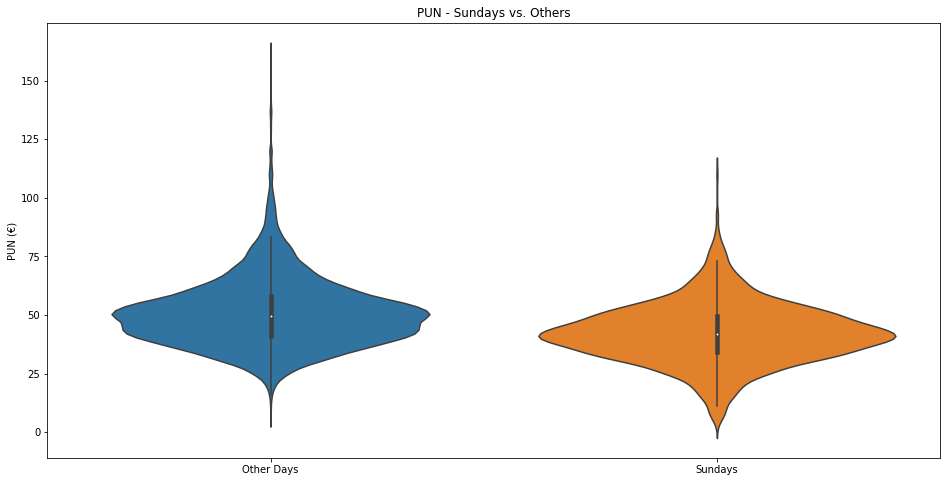

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.violinplot(x=market['sunday'], y=market['pun'], ax=ax)
ax.set_title('PUN - Sundays vs. Others')
ax.set_xlabel('')
ax.set_ylabel('PUN (€)')
ax.set_xticklabels(['Other Days', 'Sundays']);
# plt.savefig('../reports/figures/MVP_violinplot_sunday.png');

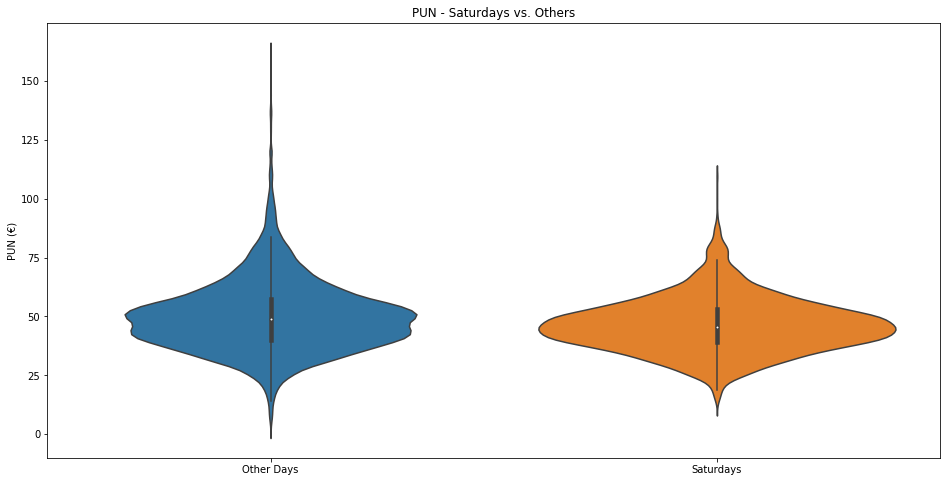

In [31]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.violinplot(x=market['saturday'], y=market['pun'], ax=ax)
ax.set_title('PUN - Saturdays vs. Others')
ax.set_xlabel('')
ax.set_ylabel('PUN (€)')
ax.set_xticklabels(['Other Days', 'Saturdays']);
# plt.savefig('../reports/figures/MVP_violinplot_saturday.png');

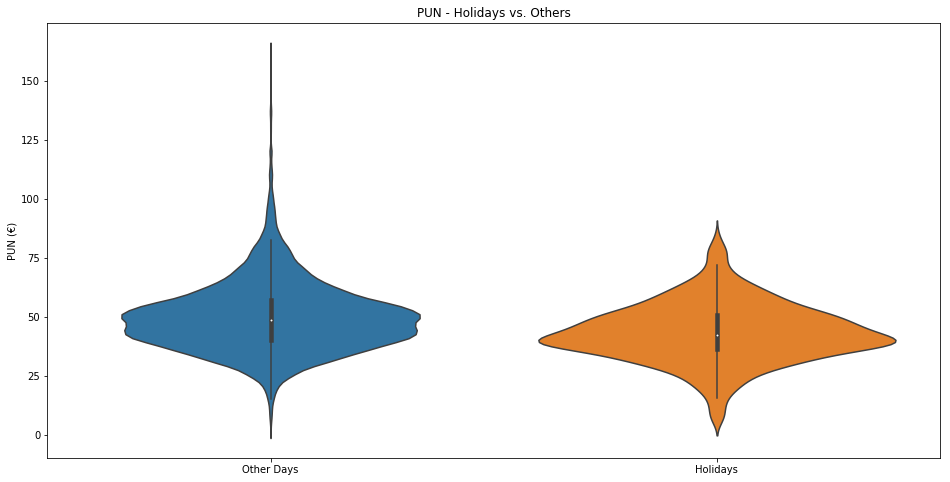

In [32]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.violinplot(x=market['holiday'], y=market['pun'], ax=ax)
ax.set_title('PUN - Holidays vs. Others')
ax.set_xlabel('')
ax.set_ylabel('PUN (€)')
ax.set_xticklabels(['Other Days', 'Holidays']);
# plt.savefig('../reports/figures/MVP_violinplot_holiday.png');

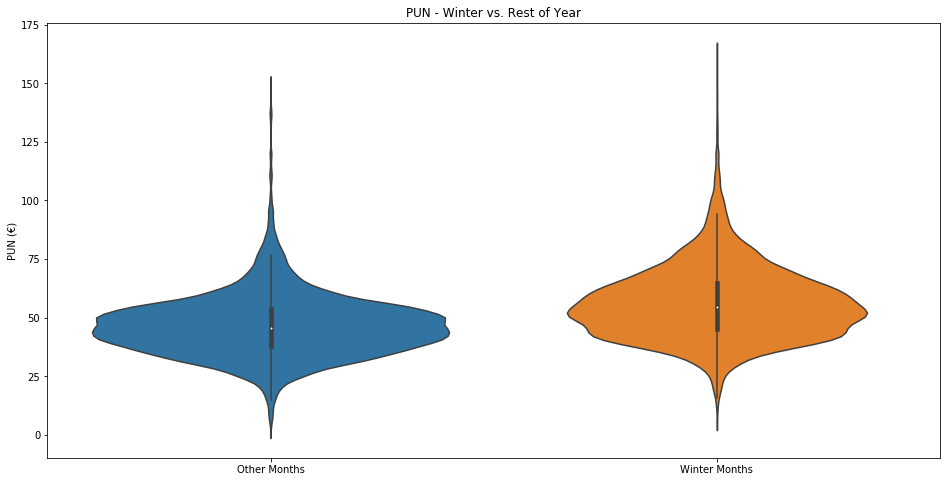

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.violinplot(x=market['winter'], y=market['pun'], ax=ax)
ax.set_title('PUN - Winter vs. Rest of Year')
ax.set_xlabel('')
ax.set_ylabel('PUN (€)')
ax.set_xticklabels(['Other Months', 'Winter Months']);
# plt.savefig('../reports/figures/MVP_violinplot_winter.png');

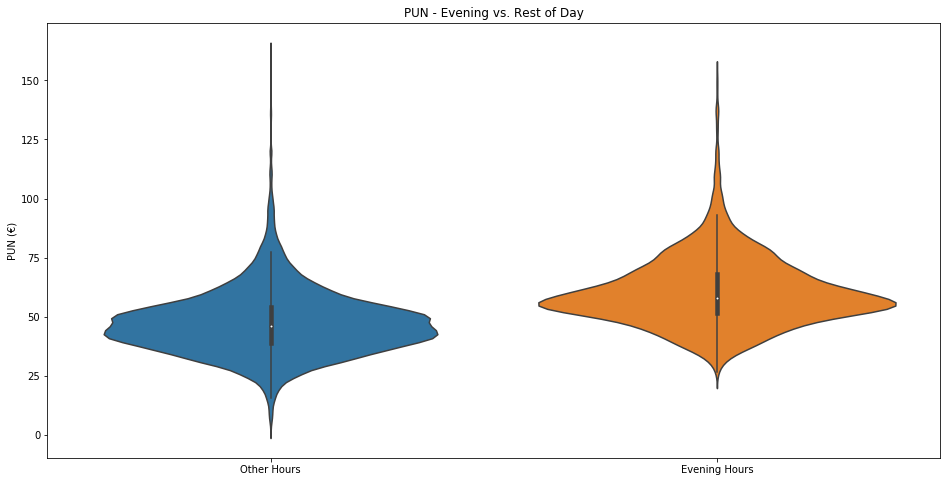

In [34]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.violinplot(x=market['evening'], y=market['pun'], ax=ax)
ax.set_title('PUN - Evening vs. Rest of Day')
ax.set_xlabel('')
ax.set_ylabel('PUN (€)')
ax.set_xticklabels(['Other Hours', 'Evening Hours']);
# plt.savefig('../reports/figures/MVP_violinplot_evening.png');

The PUN seems to be significantly different for all of the new variables.

In [35]:
market.to_pickle('..\data\processed\market_processed.pkl')

# Initial Prediction

In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

For this first model I'm using only Italy demand, the new columns added in the section above and the transi limits variables. 

As you can see from below there are some rows for which some of the transit limits are missing: for this first model I'm not using them.

In [37]:
# market = pd.read_pickle('..\data\processed\market_processed.pkl')
market[['italy', 'AUST-XAUS', 'BSP-SLOV', 'CNOR-CORS', 'CNOR-CSUD', 'CNOR-NORD',
            'CORS-CNOR', 'CORS-SARD', 'CSUD-CNOR', 'CSUD-SARD', 'FOGN-SUD', 'FRAN-XFRA',
            'NORD-CNOR', 'ROSN-SICI', 'ROSN-SUD', 'SARD-CORS', 'SARD-CSUD', 'SICI-ROSN',
            'SLOV-BSP', 'SUD-CSUD', 'XAUS-AUST', 'XFRA-FRAN', 'sunday', 'saturday',
            'holiday', 'winter', 'evening']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33596 entries, 0 to 33599
Data columns (total 27 columns):
italy        33596 non-null int64
AUST-XAUS    23853 non-null float64
BSP-SLOV     33596 non-null float64
CNOR-CORS    33596 non-null float64
CNOR-CSUD    33596 non-null float64
CNOR-NORD    33596 non-null float64
CORS-CNOR    33596 non-null float64
CORS-SARD    33596 non-null float64
CSUD-CNOR    33596 non-null float64
CSUD-SARD    33596 non-null float64
FOGN-SUD     33596 non-null float64
FRAN-XFRA    23853 non-null float64
NORD-CNOR    33596 non-null float64
ROSN-SICI    33596 non-null float64
ROSN-SUD     33596 non-null float64
SARD-CORS    33596 non-null float64
SARD-CSUD    33596 non-null float64
SICI-ROSN    33596 non-null float64
SLOV-BSP     33596 non-null float64
SUD-CSUD     33596 non-null float64
XAUS-AUST    23853 non-null float64
XFRA-FRAN    23853 non-null float64
sunday       33596 non-null int64
saturday     33596 non-null int64
holiday      33596 non-null int64

In [38]:
X = market[['italy', 'BSP-SLOV', 'CNOR-CORS', 'CNOR-CSUD', 'CNOR-NORD',
            'CORS-CNOR', 'CORS-SARD', 'CSUD-CNOR', 'CSUD-SARD', 'FOGN-SUD',
            'NORD-CNOR', 'ROSN-SICI', 'ROSN-SUD', 'SARD-CORS', 'SARD-CSUD', 'SICI-ROSN',
            'SLOV-BSP', 'SUD-CSUD', 'sunday', 'saturday', 'holiday', 'winter', 'evening']]
y = market['pun']

In [39]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

I'm using a random forest and doing a grid search to tune the n_estimators and max_features parameters:

In [40]:
forest = RandomForestRegressor()

In [44]:
param_grid = {'n_estimators':np.arange(10, 110, 20),
             'max_features':np.arange(1, X.shape[1]+1)}

gs = GridSearchCV(estimator=forest, param_grid=param_grid, n_jobs=-1, cv=10)
gs.fit(Xtrain, ytrain)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([10, 30, 50, 70, 90]), 'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [45]:
print(gs.best_score_)
print(gs.best_params_)

0.819507801582
{'max_features': 5, 'n_estimators': 90}


The best parameters are 5 features and 90 estimators, now I try to fit the model and take a look at training and test errors. I'm using $R^2$ and both mean squared error and mean absolute error. I'm also using the mean absolute error percentage to get a measure of how much I'm far away from the PUN.

In [41]:
forest.set_params(n_estimators=90, max_features=5)
forest.fit(Xtrain, ytrain)
ypred = forest.predict(Xtrain)
print(forest.score(Xtrain, ytrain))
print(mean_squared_error(ypred, ytrain))
print(mean_absolute_error(ypred, ytrain))
print(mean_absolute_error(ypred, ytrain) / ytrain.mean())

0.97501720591
5.38865690754
1.54252454736
0.0311133316434


I get a training $R^2$ of 97.5%, which is not bad; this corresponds to a MAE of 1.54€, which is the 3% of the mean PUN.

The training metrics are quite good, let's also look at the residuals:

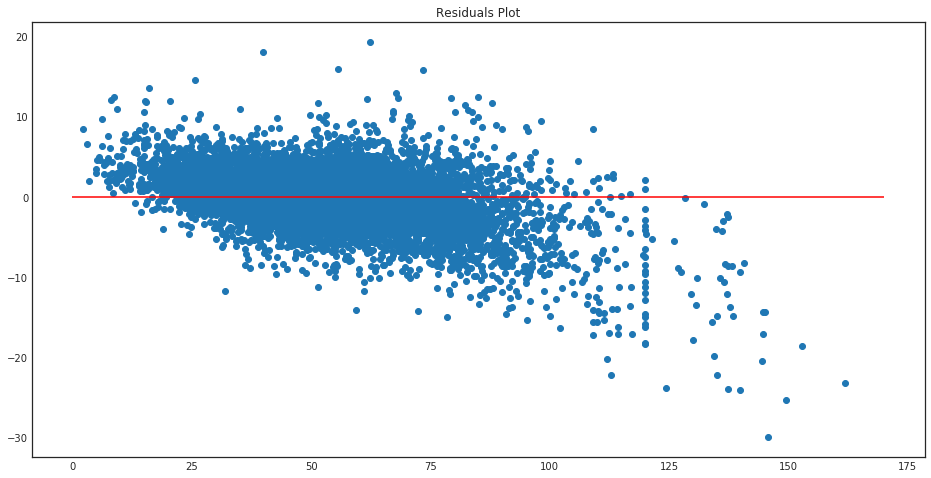

In [42]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(16, 8))
    plt.scatter(ytrain, ypred - ytrain)
    plt.hlines(y=0, xmin=0, xmax=170, colors='r')
    plt.title('Residuals Plot');
    # plt.savefig('../reports/figures/MVP_forest_residuals.png');

The residuals doesn't seem to be randomly distributed around zero. There is a definite downward trend, meaning that I'm predicting higher prices when the PUN is low and smaller prices when it is higher.

In [43]:
ypred = forest.predict(Xtest)
print(forest.score(Xtest, ytest))
print(mean_squared_error(ypred, ytest))
print(mean_absolute_error(ypred, ytest))
print(mean_absolute_error(ypred, ytest) / ytest.mean())

0.821139684523
40.8491221856
4.21229985617
0.0846680024618


The test $R^2$ is 82%, so I'm overfitting a bit the data. The test MAE is 4.21€, which is the 8.5% of the mean PUN.

Overall this is a good first model but it can be better.

# Conclusions

### Initial Findings

- PUN shows differences between the months in the year, days of the week and hours in the day
- The initial model doesn't capture all the data variance, as it is shown by the residuals plot

### Further Reasearch

- Investigate difference between years and try to incorporate it
- Try to get better predictions of the price peaks
- Add new features to get better predictions (a very good result would be a MAE of under 2€, an excellent one under 1€)
- Deeper EDA considering the time series aspect
- Add new data from other sources (e.g. weather forecasts)